In [2]:
import os, sys, time
import tifffile as tif
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

from scipy import ndimage
import scipy.stats as st
import seaborn as sns

In [5]:
# set a base directory where your folders live
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/"

In [10]:
# make a list of all the volumes
#manually change the # in line 11
vol_list = ["k320","a235", "c514_3","e106","tom1","tom2","tom3","tom4"]
mouse_vols = []
rat_vols = []

for i in np.arange(len(vol_list)):
    fld = os.path.join(src,"output_dirs/{}_in_m_matlas_alt".format(vol_list[i]))
    jac = tif.imread(os.path.join(fld,"spatialJacobian.tif"))
    adjjac = jac/np.median(jac)
    tif.imsave(os.path.join(src,"tiffs/{}_adjjac.tif".format(vol_list[i])),adjjac)
    if i < 4:
        print("adding {} to rat_vols".format(vol_list[i]))
        rat_vols.append(adjjac)
    else:
        print("adding {} to mouse_vols".format(vol_list[i]))
        mouse_vols.append(adjjac)

adding k320 to rat_vols
adding a235 to rat_vols
adding c514_3 to rat_vols
adding e106 to rat_vols
adding tom1 to mouse_vols
adding tom2 to mouse_vols
adding tom3 to mouse_vols
adding tom4 to mouse_vols


In [13]:
avg_mouse = np.mean(mouse_vols,0)
avg_rat = np.mean(rat_vols,0)

tif.imsave(os.path.join(src,'tiffs/avgjac_mouse_alt.tif'),avg_mouse)
tif.imsave(os.path.join(src,'tiffs/avgjac_rat_alt.tif'),avg_rat)

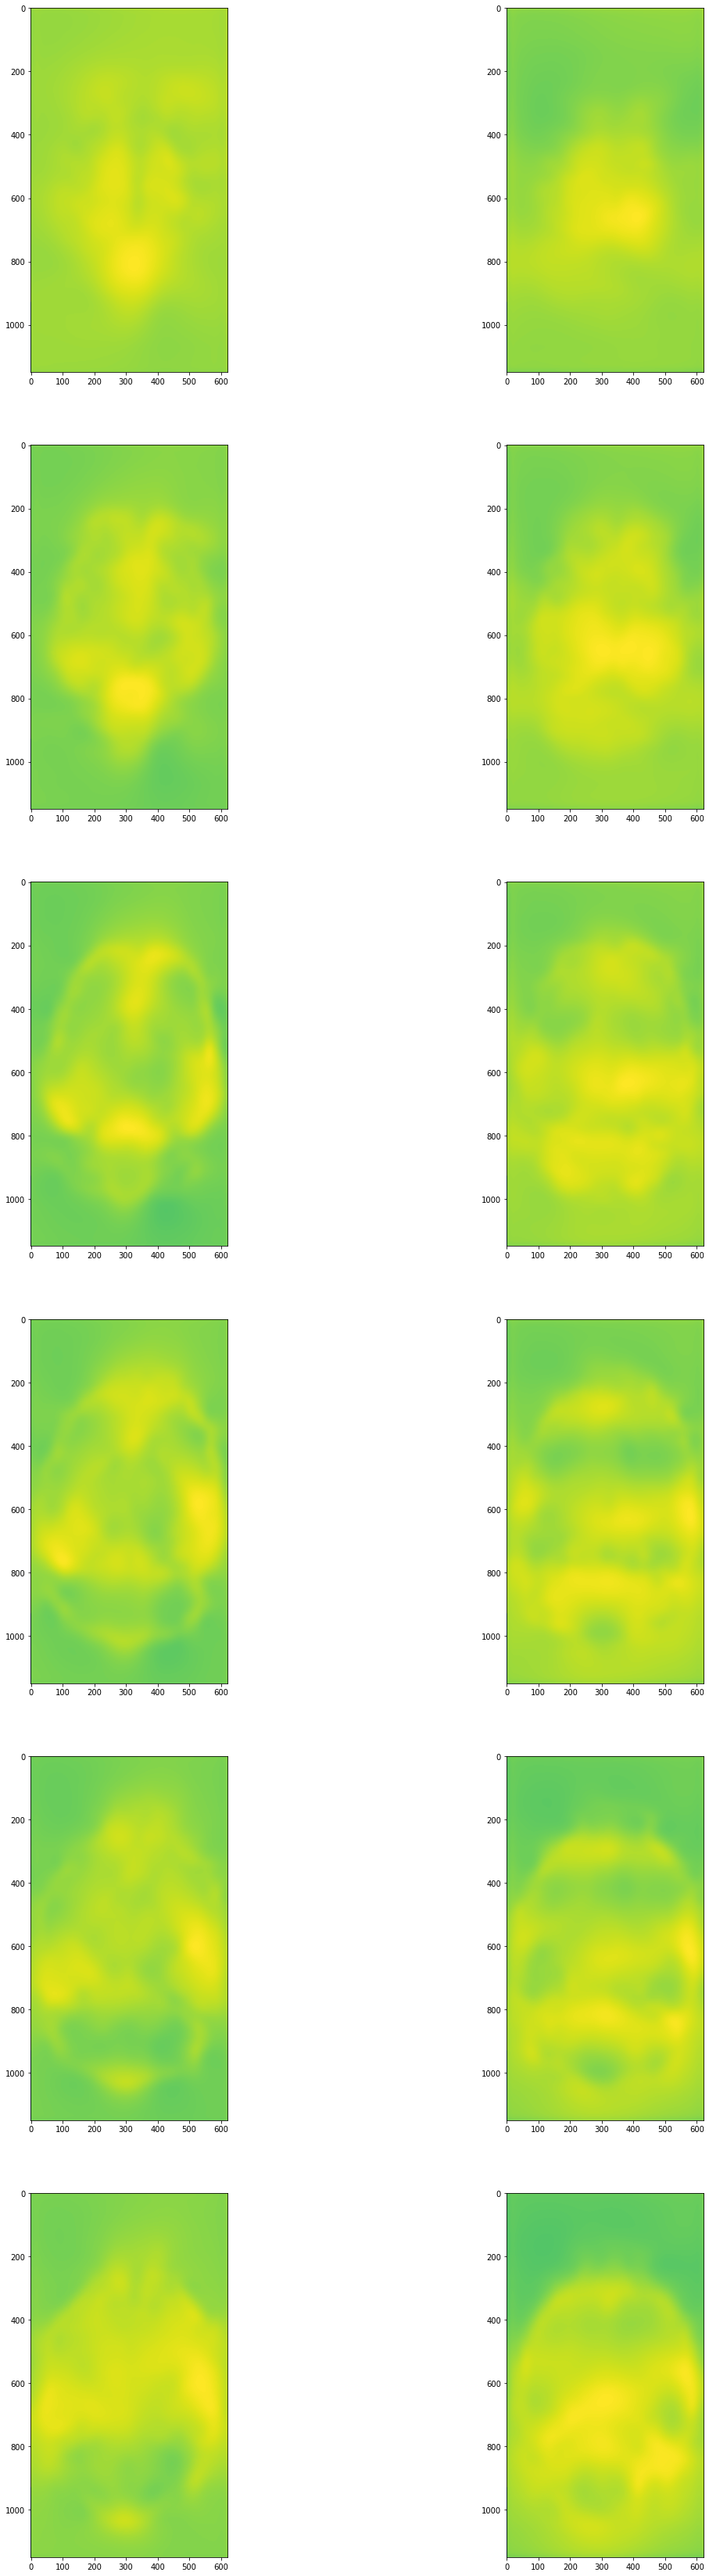

In [16]:
listtoplot = [50,100,150,200,250,300]
l = len(listtoplot)    
fig,ax = plt.subplots(l,2,figsize=(20,60))

for i in np.arange(0,l):
    ax[i,0].imshow(ndimage.rotate(avg_mouse[:,:,listtoplot[i]],-90))
    ax[i,1].imshow(ndimage.rotate(avg_rat[:,:,listtoplot[i]],-90))
plt.show()

In [ ]:
# 2021-03-05 stopped here -- waiting on elastix/transformix of labeled volume to m_matlas_alt space

In [25]:
labels_nona = sigma_labs.dropna()
labels_nona.insert(5,'jac_val',0)
labels_nona.jac_val[labels_nona.index[labels_nona.id==11]]

0    0
Name: jac_val, dtype: int64

In [37]:
# need to get sigma in ratmouse space, then import that
sigma = tif.imread('/Users/emilydennis/Desktop/sigmaann_mr.tif')

In [13]:
rmb = tif.imread('/Users/emilydennis/Desktop/net_matlas/ratpink_mouseblue_0.tif')
whs = tif.imread('/Users/emilydennis/Desktop/atl/whs_result.tif')
chon = tif.imread('/Users/emilydennis/Desktop/atl/Chon_result.tif')
chon_labs = pd.read_csv('/Users/emilydennis/Desktop/lightsheet/labels/chon_label_ids.csv')
whs_labs = pd.read_csv('/Users/emilydennis/Desktop/lightsheet/labels/labels_v3.csv')
sigma_labs = pd.read_csv("/Users/emilydennis/Desktop/20210220/SIGMA_labels_withPRA.csv")

labels_nona = sigma_labs.dropna()

labels_nona

,atlas,id,name,praid,parent
0,tohoku,11.0,agranular_dysgranular_insular_cortex,1140.0,insula
1,tohoku,12.0,agranular_dysgranular_insular_cortex,1140.0,insula
2,tohoku,21.0,agranular_insular_cortex,1140.0,insula
3,tohoku,22.0,agranular_insular_cortex,1141.0,insula
4,tohoku,31.0,amygdalohyppocampic_area,100.0,amygdala
...,...,...,...,...,...
229,waxholm,1152.0,ventral_hippocampal_commissure,12000.0,medial_forebrain_bundle
230,waxholm,1161.0,periventricular_grey,9110.0,thalamus
231,waxholm,1162.0,periventricular_grey,9110.0,thalamus
232,sigma,1171.0,ventricular_system,13000.0,ventricles


In [38]:
np.shape(rmb)

(592, 686, 416)

In [30]:
chon_nona['Franklin-Paxinos Full name']

,id,Franklin-Paxinos abbreviation,Franklin-Paxinos Full name,Unnamed: 3,structure Order,red,green,blue,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,jac_val
0,1,VTM,Ventral tuberomammillary nucleus,NaN,75500.0,255.0,78.0,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.288065
1,2,S1ULp-6b,"Primary somatosensory cortex, upper lip region...",NaN,6200.0,137.0,205.0,161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.169721
2,3,sf,secondary fissure,NaN,118200.0,170.0,170.0,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,IC,Inferior colliculus,NaN,79100.0,255.0,152.0,255.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,ic,internal capsule,NaN,107000.0,204.0,204.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.119730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4284,58500,8Cb-mo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4285,59100,9Cb-gr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4286,58900,9Cb-mo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4287,59500,10Cb-gr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
chon_nona = chon_labs.copy()
chon_nona.insert(15,'jac_val',0)

In [28]:
for i in np.unique(chon_nona['id']):
    print(i)
    chon_nona.jac_val[chon_nona.index[chon_nona.id==i]] = np.mean(rmb[chon==i])

1


/Users/emilydennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2
3


/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


4
6
7
8
9
10
11
12
14
15
16
17
19
20
21
22
23
26
27
28
30
31
33
34
35
36
37
38
39
41
42
43
44
45
46
48
50
51
52
54
55
56
58
59
60
62
63
64
65
66
67
68
71
73
74
75
78
79
81
82
83
84
85
87
88
91
92
93
94
95
96
97
98
99
100
101
102
104
105
106
108
111
112
113
114
115
117
119
120
121
122
123
124
125
129
130
131
132
133
135
136
137
138
139
140
141
145
147
148
149
151
153
154
155
156
157
158
159
160
161
162
163
164
165
167
168
169
170
171
173
175
177
178
180
181
183
184
186
187
188
189
190
191
192
194
195
196
197
198
199
200
201
202
203
204
206
207
208
209
210
211
212
214
215
216
217
218
220
222
223
224
225
226
228
229
230
231
232
233
234
235
236
237
238
239
240
242
243
244
246
247
248
250
251
252
254
255
256
257
258
259
260
262
266
267
268
269
271
272
274
275
276
278
280
281
284
286
287
289
290
291
292
293
294
295
296
298
300
301
302
303
304
305
310
311
312
313
314
315
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
341
342
343
344
345
346
347
348
351

28936
29000
29100
29200
29300
29400
29500
29600
29700
29800
29900
30000
30100
30200
30300
30400
30500
30600
30700
30800
30900
30910
31000
31100
31200
31300
31400
31500
31510
31520
31600
31700
31800
31900
32100
32200
32300
32400
32500
32700
32800
32900
33000
33100
33200
33300
33400
33500
33510
33600
33800
33900
34000
34010
34020
34030
34040
34100
34300
34400
34500
34600
34700
34800
34900
35000
35100
35200
35500
35600
35700
35800
36100
36200
36300
36400
36600
36700
36800
36900
37100
37200
37300
37400
37500
37600
37700
37800
37900
38000
38100
38200
38300
38400
38500
38600
38700
38800
38900
39000
39100
39200
39300
39400
39500
39600
41000
41100
41200
41300
41350
41400
41500
41600
41700
41800
41900
42000
42100
42200
42300
42400
42500
42700
42800
42900
43000
43100
43110
43200
43300
43400
43500
43600
43700
43800
43900
44000
44100
44200
44220
44230
44240
44250
44260
44270
44280
44290
44291
44292
44293
44294
44300
44400
44500
44600
44700
44800
44900
45000
45100
45200
45300
45400
45500
45600
4570

In [15]:
whs_nona = whs_labs.dropna()
whs_nona.insert(3,'jac_val',0)

In [16]:
for i in np.unique(whs_nona['id']):
    print(i)
    whs_nona.jac_val[whs_nona.index[whs_nona.id==i]] = np.mean(rmb[whs==i])

0


/Users/emilydennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1
2
3
4
5
6
7
10
30
31
32
33
34
35
36
37
38
39
40
41
42
43
45
46
47
48
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
92
93
94
95
96
97
98
99
100
108
109
110
112
113
114
115
119
120
121
122
123
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
145
146
147
148
149
150
151
152
153
157
158
159
160
162
163
164


In [62]:
df = labels_nona.groupby(['name'],as_index=False).mean()
df = df.sort_values(by=['jac_val'])
df

,name,id,praid,jac_val
100,secondary_cingular_cortex,701.5,1123.0,-0.244344
103,septal_region,1061.5,9010.0,-0.231509
113,ventral_hippocampal_commissure,1151.5,12000.0,-0.218113
79,primary_cingular_cortex,501.5,1123.0,-0.201865
9,bed_nucleus_of_the_stria_terminalis,61.5,7200.0,-0.199927
...,...,...,...,...
41,inferior_cerebellum_peduncle/spinal_trigeminal...,961.5,6100.0,0.221452
42,inferior_olive/pyramidaldecusation/sp5,1031.5,5110.0,0.243345
58,middle_cerebellum_peduncle_,1011.5,12000.0,0.319860
11,brachium_pontis,1141.5,200.0,0.344363


In [31]:
df = chon_nona.groupby(['Franklin-Paxinos Full name'],as_index=False).mean()
df = df.sort_values(by=['jac_val'])
df

,Franklin-Paxinos Full name,id,Unnamed: 3,structure Order,red,green,blue,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,jac_val
202,"Cingulate cortex, area 24a2, layer1",588.0,NaN,19600.0,109.0,191.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.248823
195,"Cingulate cortex, area 24a (infralimbic), layer 1",707.0,NaN,8500.0,0.0,137.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.245987
462,Induseum griseum,19.0,NaN,41100.0,114.0,254.0,114.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.241804
197,"Cingulate cortex, area 24a (infralimbic), layer 4",556.0,NaN,8700.0,50.0,146.0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.238070
157,"Caudoputamen- intermediate, ventrolateral, int...",2479.0,NaN,48244.0,160.0,216.0,248.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.237240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,trapezoid body,841.0,NaN,100800.0,204.0,204.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1411,trigeminal nerve,901.0,NaN,99600.0,204.0,204.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1412,trochlear nerve,911.0,NaN,99300.0,204.0,204.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1414,vagus nerve,917.0,NaN,101500.0,204.0,204.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


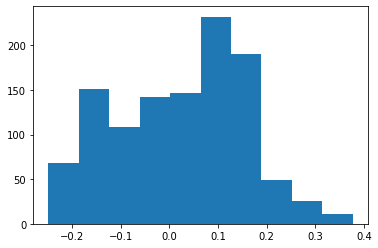

(0.013118003718646715, 0.03534212000763693)

In [33]:
plt.hist(df['jac_val'])
plt.show()
a=df['jac_val'].dropna()
st.t.interval(0.995, len(a)-1, loc=np.mean(a), scale=st.sem(a))

In [102]:
dfpt18 = df.copy()
dfpt18 = dfpt18[abs(df.jac_val)>.28]
#dfpt18 = dfpt18[((df.jac_val) < -.22)]

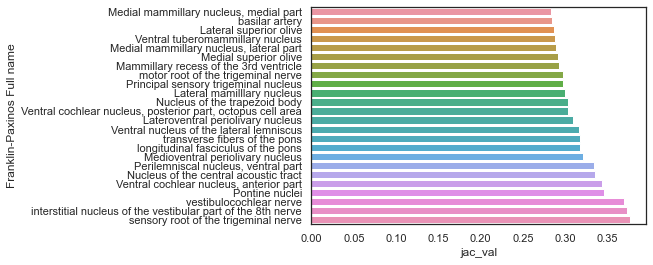

In [103]:
sns.set(font_scale=1,style='white')
sns.barplot(data=dfpt18,x='jac_val',y='Franklin-Paxinos Full name')
plt.show()

In [104]:
whsjac = tif.imread('/Users/emilydennis/Desktop/atl/whs_spatialJacobian.tif')
mw = np.median(whsjac)
whs_netjac = whsjac/mw

In [106]:
tif.imsave('/Users/emilydennis/Desktop/atl/whs_NET_spatialJacobian.tif',whs_netjac)

In [127]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [139]:
a=jacvals.dropna()
st.t.interval(0.995, len(a)-1, loc=np.mean(a), scale=st.sem(a))

(-0.025072878104552616, 0.04288187544089411)

In [137]:
# also do with log transformed jacs from ea vol

/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: alpha must be between 0 and 1 inclusive

In [103]:
avgjac - 2*std

-0.24338995219192586

/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


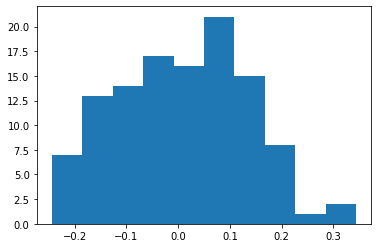

In [89]:
plt.hist(jacvals)
plt.show()

In [2]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/"
vol_list= ["tom1","tom2","tom3","tom4","e106","a235","k320","c514_3"]

6

In [230]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet"

fann = os.path.join(src,"tiffs/fPRA_to_PRA_net_jacobian.tif")
#fann = os.path.join(src,"output_dirs/SIGMA_in_fPRA/result.tif")
#fann_affine = os.path.join(src, "output_dirs/SIGMA_fPRA_in_PRA_affine/result.tif")
mann = os.path.join(src, "output_dirs/SIGMA_ann_in_PRA_25/result.tif")

#fann = os.path.join(src, "tiffs/WHS_ann_in_fPRA.tif")
#mann = os.path.join(src, "output_dirs/WHS_ann_in_PRA25/WHS_anns_in_PRA25.tif")

#annotationsfilename=os.path.join(src,"labels/labels_v3.csv")

annotationsfilename = os.path.join(src,"labels/SIGMA_good_labels.csv")
output= "/home/emilyjanedennis/Desktop/mf_SIGMA.tiff"
percentcsv="/home/emilyjanedennis/Desktop/mf_percent_SIGMA.csv"

## get percent of each brain for a given 'value' or label

In [231]:
# make sure your annotations have the first column as id number, 2nd as abbreviation, or else change the input below
anns=pd.read_csv(annotationsfilename,usecols=[0,1,2],header=0)
print("read annotations")

read annotations


In [232]:
df=anns.dropna()
df


,atlas,ID,label
0,Tohoku,11,Agranular Dysgranular Insular Cortex
1,Tohoku,12,Agranular Dysgranular Insular Cortex
2,Tohoku,21,Agranular Insular Cortex
3,Tohoku,22,Agranular Insular Cortex
4,Tohoku,31,Amygdalohyppocampic Area
...,...,...,...
177,Waxholm,1132,Thalamus
178,Waxholm,1141,Brachium Pontis
179,Waxholm,1142,Brachium Pontis
180,Waxholm,1161,Periventricular Grey


In [233]:
df.insert(3,'fvox',0)
df.insert(4,'fvox_affine',0)
df.insert(5,'mvox',0)


In [234]:
ftiff = tif.imread(fann)
#faffinetiff = tif.imread(fann_affine)
mtiff = tif.imread(mann)
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')

In [235]:
for i in df['ID']:
    df.fvox[df.index[df.ID==i]] = np.mean(ftiff[SIGMAtiff==i])

<ipython-input-235-01c5cdf64e11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fvox[df.index[df.ID==i]] = np.mean(ftiff[SIGMAtiff==i])


In [236]:
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')
fsigmatiff = msigmatiff
np.max(fsigmatiff)

for i in np.unique(SIGMAtiff):
    if i in df['ID']:
        print(i)
    else:
        fsigmatiff[fsigmatiff==i]=0

0
11
12
21
22
31
32
41
42
51
52
61
62
71
72
81
82
91
92
101
102
111
112
121
122
131
132
141
142
151
152
161
162
171
172
181


In [237]:
np.max(fsigmatiff)

181

In [238]:
for i in df['ID']:
    val = (df.fvox[df.ID==i])*1000
    print(val.astype('int16'))
    if val.item() > 0.1:
        print(np.shape(fsigmatiff[fsigmatiff==i]))
        fsigmatiff[fsigmatiff==i]=val.astype('int16')

0    7
Name: fvox, dtype: int16
(54968,)


<ipython-input-238-ae2ce6616ac2>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  if val.item() > 0.1:


1    221
Name: fvox, dtype: int16
(55343,)
2    37
Name: fvox, dtype: int16
(372549,)
3    234
Name: fvox, dtype: int16
(383733,)
4    116
Name: fvox, dtype: int16
(35191,)
5    78
Name: fvox, dtype: int16
(32045,)
6    149
Name: fvox, dtype: int16
(273770,)
7    170
Name: fvox, dtype: int16
(252711,)
8    196
Name: fvox, dtype: int16
(1323564,)
9    210
Name: fvox, dtype: int16
(1365468,)
10    271
Name: fvox, dtype: int16
(44955,)
11    289
Name: fvox, dtype: int16
(45487,)
12    174
Name: fvox, dtype: int16
(503913,)
13    165
Name: fvox, dtype: int16
(484677,)
14    178
Name: fvox, dtype: int16
(80373,)
15    170
Name: fvox, dtype: int16
(77194,)
16    234
Name: fvox, dtype: int16
(463119,)
17    243
Name: fvox, dtype: int16
(437168,)
18    236
Name: fvox, dtype: int16
(711879,)
19    244
Name: fvox, dtype: int16
(676271,)
20    117
Name: fvox, dtype: int16
(84468,)
21    378
Name: fvox, dtype: int16
(80631,)
22    74
Name: fvox, dtype: int16
(206293,)
23    178
Name: fvox, dtype: 

In [239]:
np.max(fsigmatiff)

405

In [240]:
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')
msigmatiff= SIGMAtiff
np.max(fsigmatiff)

for i in np.unique(SIGMAtiff):
    if i in df['ID']:
        print(i)
    else:
        msigmatiff[msigmatiff==i]=0


0
11
12
21
22
31
32
41
42
51
52
61
62
71
72
81
82
91
92
101
102
111
112
121
122
131
132
141
142
151
152
161
162
171
172
181


In [241]:
for i in df['ID']:
    val = (df.fvox[df.ID==i])*1000
    print(val.astype('int16'))
    if val.item() < 0:
        print(np.shape(msigmatiff[msigmatiff==i]))
        msigmatiff[msigmatiff==i]=val.astype('int16')

0    7
Name: fvox, dtype: int16
1    221
Name: fvox, dtype: int16
2    37
Name: fvox, dtype: int16
3    234
Name: fvox, dtype: int16
4    116
Name: fvox, dtype: int16
5    78
Name: fvox, dtype: int16
6    149
Name: fvox, dtype: int16
7    170
Name: fvox, dtype: int16
8    196
Name: fvox, dtype: int16
9    210
Name: fvox, dtype: int16
10    271
Name: fvox, dtype: int16
11    289
Name: fvox, dtype: int16
12    174
Name: fvox, dtype: int16
13    165
Name: fvox, dtype: int16
14    178
Name: fvox, dtype: int16
15    170
Name: fvox, dtype: int16
16    234
Name: fvox, dtype: int16
17    243
Name: fvox, dtype: int16
18    236
Name: fvox, dtype: int16
19    244
Name: fvox, dtype: int16
20    117
Name: fvox, dtype: int16
21    378
Name: fvox, dtype: int16
22    74
Name: fvox, dtype: int16
23    178
Name: fvox, dtype: int16
24    36
Name: fvox, dtype: int16
25    1
Name: fvox, dtype: int16
26    233
Name: fvox, dtype: int16
27    235
Name: fvox, dtype: int16
28    241
Name: fvox, dtype: int16
29 

<ipython-input-241-21cdfcfacca2>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  if val.item() < 0:


50    132
Name: fvox, dtype: int16
51    70
Name: fvox, dtype: int16
52    200
Name: fvox, dtype: int16
53    195
Name: fvox, dtype: int16
54    185
Name: fvox, dtype: int16
55    116
Name: fvox, dtype: int16
56    188
Name: fvox, dtype: int16
57    131
Name: fvox, dtype: int16
58    100
Name: fvox, dtype: int16
59    379
Name: fvox, dtype: int16
60    137
Name: fvox, dtype: int16
61    55
Name: fvox, dtype: int16
62    110
Name: fvox, dtype: int16
63    55
Name: fvox, dtype: int16
64    13
Name: fvox, dtype: int16
65   -52
Name: fvox, dtype: int16
(0,)
66    89
Name: fvox, dtype: int16
67    16
Name: fvox, dtype: int16
68    252
Name: fvox, dtype: int16
69    257
Name: fvox, dtype: int16
70    120
Name: fvox, dtype: int16
71    61
Name: fvox, dtype: int16
72    98
Name: fvox, dtype: int16
73    10
Name: fvox, dtype: int16
74    103
Name: fvox, dtype: int16
75    34
Name: fvox, dtype: int16
76    181
Name: fvox, dtype: int16
77    164
Name: fvox, dtype: int16
78    113
Name: fvox, dtyp

In [242]:
tif.imsave('/home/emilyjanedennis/Desktop/msigma.tif',msigmatiff)
tif.imsave('/home/emilyjanedennis/Desktop/fsigma.tif',fsigmatiff)

array([], dtype=int16)

In [146]:
print(np.max(SIGMAtiff))
print(np.min(SIGMAtiff))

0
0


In [8]:
for i in df['ID']:
    df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])
    df.mvox[df.index[df.ID==i]] = np.size(mtiff[mtiff==i])


<ipython-input-8-5162a856bfbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])


In [9]:
df = df[df.fvox > 0]


In [10]:
df

,atlas,ID,label,fvox,fvox_affine,mvox


In [10]:
df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
df['fpct_affine'] = (df['fvox_affine']/np.sum(df.fvox_affine))*100
df['mpct'] = (df['mvox']/np.sum(df.mvox))*100
df['fa_m_over_fam']= (df['fpct_affine']-df['mpct'])/(df['fpct_affine']+df['mpct'])
df['fa_vox_vs_m'] = (df.fvox_affine - df.mvox)/(df.mvox)
df

<ipython-input-10-cd99e5788101>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
<ipython-input-10-cd99e5788101>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fpct_affine'] = (df['fvox_affine']/np.sum(df.fvox_affine))*100
<ipython-input-10-cd99e5788101>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

,atlas,ID,label,fvox,fvox_affine,mvox,fpct,fpct_affine,mpct,fa_m_over_fam,fa_vox_vs_m
1,Waxholm,171,Globus Pallidus,2572,3265,2844,0.004230,0.004364,0.004000,0.043506,0.148031
2,Waxholm,731,Striatum,1466457,1813067,1664466,2.411643,2.423155,2.340903,0.017265,0.089278
3,Waxholm,221,Granule Cell Level of the Cerebellum,1018451,1259382,1265190,1.674881,1.683158,1.779362,-0.027784,-0.004591
4,Waxholm,341,Molecular Layer of the Cerebellum,3429328,4238434,4095170,5.639657,5.664646,5.759442,-0.008298,0.034984
5,Tohoku,31,Amygdalohyppocampic Area,26485,32843,35191,0.043556,0.043895,0.049493,-0.059945,-0.066722
...,...,...,...,...,...,...,...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,2630,3297,2401,0.004325,0.004406,0.003377,0.132293,0.373178
230,Waxholm,902,Deeper Layers of the Superior Colliculus,433198,535986,440010,0.712410,0.716343,0.618829,0.073034,0.218122
231,Waxholm,1082,SP5,24785,30876,29813,0.040760,0.041266,0.041929,-0.007973,0.035656
232,Waxholm,792,Anterior Commissure Intrabulbar part,37530,46420,45913,0.061719,0.062040,0.064572,-0.019997,0.011043


In [11]:
df.to_csv('/home/emilyjanedennis/Desktop/fa_vals.csv')

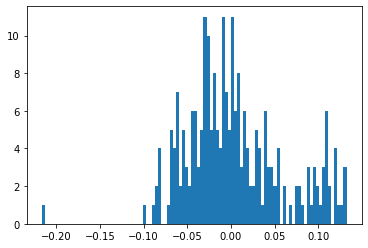

In [13]:
plt.hist(df.fa_m_over_fam,bins=100)
plt.show()

In [70]:
mp = 0
sp = np.nanstd(df.fg)

In [71]:
highmp = mp+sp
highmp
highermp = mp+(2*sp)

In [72]:
lowmp = mp-(0.5*sp)
lowmp
lowermp=mp-(2*sp)

In [17]:
df=pd.read_csv(percentcsv)

In [69]:
mp

-0.0045578046095393135

1162

In [148]:
# want to take IDs and set all to 0 except fg > highmp == 800, fg > higher mp == 1000
# fg < lowmp == 600, fg < lowermp == 500
# then save the tiff
sex_relative = tif.imread(mann)
np.max(sex_relative)

for i in df['ID']:
    if df[df['ID']==i]['fg'].item() >.09:
        sex_relative[sex_relative==i]=1000
    else:
        sex_relative[sex_relative==i]=0

In [149]:
tif.imsave('/home/emilyjanedennis/Desktop/hi_sigma.tif',sex_relative)

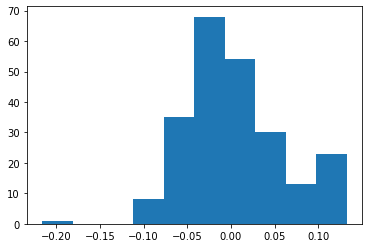

In [104]:
plt.hist(df['fg'])
plt.show()

In [142]:
np.sum(df['fg']<-.06)

24

In [143]:
np.sum(df['fg']>.09)

27

-0.11149420498351735